# Titanic Dataset - Sklearn Stacking Classifier

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# ReadIn the training data
titanic_train = pd.read_csv("titanic_train.csv")
print (titanic_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## Variable Notes

>pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

>age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

>sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancÃ©s were ignored)

>parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [3]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Separate out the target/ label from the dataset

In [5]:
print(f'All column names: {titanic_train.columns}')
X_train = titanic_train.copy()
y_train = X_train.pop('Survived')
print(f'Training data column names: {X_train.columns}')
print(f'Training label: {y_train.name}')

All column names: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Training data column names: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Training label: Survived


## Helper Functions

In [6]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    # print (big_string)
    return np.nan

def replace_titles(x):
    title=x['salut']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

## Data Preprocessing - Training Data

In [7]:
# Split Name and extract the salutation

X_train['salut'] = X_train['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0].str.strip()
print("Unique values from salut - training dataset:\n", X_train['salut'].unique(), "\n")

print ("salut Before:")
print (X_train['salut'].value_counts(), "\n")

# X_train.drop(['firstname', 'last_name', 'lastname', 'lastname1'], axis=1, inplace=True)
print (X_train.columns, "\n")

X_train['salut']=X_train.apply(replace_titles, axis=1)
print ("salut After:")
print (X_train['salut'].value_counts())

Age_salut = pd.crosstab(X_train.Age, X_train.salut)
Age_salut.tail(10)

Unique values from salut - training dataset:
 ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer'] 

salut Before:
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Ms                1
Jonkheer          1
the Countess      1
Capt              1
Mme               1
Lady              1
Sir               1
Don               1
Name: salut, dtype: int64 

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'salut'],
      dtype='object') 

salut After:
Mr        531
Miss      185
Mrs       135
Master     40
Name: salut, dtype: int64


salut,Master,Miss,Mr,Mrs
Age,,,,
62.0,0,0,3,1
63.0,0,1,0,1
64.0,0,0,2,0
65.0,0,0,3,0
66.0,0,0,1,0
70.0,0,0,2,0
70.5,0,0,1,0
71.0,0,0,2,0
74.0,0,0,1,0


## Imputing data to fill in the missing values

In [8]:
# Imputing Age - We are using the 'salut' feature to group the respondent to impute the age
print ("Null values for Age before imputation: ", X_train['Age'].isnull().sum())
X_train['Age'] = X_train.groupby('salut').Age.transform(lambda x: x.fillna(x.mean()))
print ("Null values for Age after imputation: ", X_train['Age'].isnull().sum())

Null values for Age before imputation:  177
Null values for Age after imputation:  0


In [9]:
# Imputing Cabin - This cannot be imputed as there is no logic and hence we fill the NAs with 'Null' string
print("Null values for Cabin before imputation: ", X_train['Cabin'].isnull().sum())

print("Value Counts of Cabin - Before")
print (X_train['Cabin'].value_counts(dropna = False))

X_train['Cabin'] = X_train['Cabin'].fillna('Null')

print("Value Counts of Cabin - After")
print (X_train['Cabin'].value_counts(dropna = False))

Null values for Cabin before imputation:  687
Value Counts of Cabin - Before
NaN            687
B96 B98          4
C23 C25 C27      4
G6               4
C22 C26          3
              ... 
B80              1
B101             1
C99              1
E12              1
E49              1
Name: Cabin, Length: 148, dtype: int64
Value Counts of Cabin - After
Null           687
C23 C25 C27      4
G6               4
B96 B98          4
F33              3
              ... 
B80              1
B101             1
C99              1
E12              1
E31              1
Name: Cabin, Length: 148, dtype: int64


In [10]:
# Imputing the whole dataset just in case there are any furhter missing values
X_train = X_train.fillna(method='ffill').fillna(method='bfill')
print("Null values after imputation: ")
print(X_train.isnull().sum())

Null values after imputation: 
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
salut          0
dtype: int64


## Feature Engineering

In [11]:
# Deck
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Null']
X_train['Deck']=X_train['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

X_train['Deck'].value_counts()

Null    687
C        59
B        47
E        33
D        33
A        15
F        12
G         4
T         1
Name: Deck, dtype: int64

In [12]:
# Family Size and Fare per Passenger
X_train['FamilySize'] = X_train['SibSp'] + X_train['Parch'] + 1
# X_train['FarePerPassenger'] = X_train['Fare']/(X_train['FamilySize'])

print(X_train['FamilySize'].value_counts())
# print()
# print(X_train['FarePerPassenger'].value_counts())

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64


## Converting Categorical and String features into Numeric

In [14]:
# Drop features which are unique across respondents as they are not useful
X_train.drop(['Name', 'PassengerId'], axis=1, inplace=True)

# One Hot Encoding - To convert categorical to binary data
X_train_dummies = pd.get_dummies(X_train, columns=['Pclass', 'Sex', 'Cabin', 'Embarked', 'salut', 'Ticket', 'Deck'])

print ("Shape of training dataset after One Hot Encoding: ", X_train_dummies.shape)
print (X_train_dummies.head())

Shape of training dataset after One Hot Encoding:  (891, 855)
    Age  SibSp  Parch     Fare  FamilySize  Pclass_1  Pclass_2  Pclass_3  \
0  22.0      1      0   7.2500           2         0         0         1   
1  38.0      1      0  71.2833           2         1         0         0   
2  26.0      0      0   7.9250           1         0         0         1   
3  35.0      1      0  53.1000           2         1         0         0   
4  35.0      0      0   8.0500           1         0         0         1   

   Sex_female  Sex_male  ...  Ticket_WE/P 5735  Deck_A  Deck_B  Deck_C  \
0           0         1  ...                 0       0       0       0   
1           1         0  ...                 0       0       0       1   
2           1         0  ...                 0       0       0       0   
3           1         0  ...                 0       0       0       1   
4           0         1  ...                 0       0       0       0   

   Deck_D  Deck_E  Deck_F  Deck_G  D

## Test Data - ReadIn, Preprocess, Imputing, Feature Engineering and One Hot Encoding

In [15]:
# ReadIn the test data

titanic_test = pd.read_csv("titanic_test.csv")

In [16]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [17]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [18]:
titanic_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [19]:
X_test = titanic_test.copy()

# Split Name and extract the salutation
X_test['salut'] = X_test['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0].str.strip()
print("Unique values from salut - test dataset:\n", X_test['salut'].unique())

print ("salut Before:")
print (X_test['salut'].value_counts())

print (X_test.columns)

X_test['salut']=X_test.apply(replace_titles, axis=1)

print ("salut After:")
print (X_test['salut'].value_counts())

Age_salut_test = pd.crosstab(X_test.Age, X_test.salut)
print(Age_salut_test.head(6))
print(Age_salut_test.tail(6))

Unique values from salut - test dataset:
 ['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']
salut Before:
Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Ms          1
Dr          1
Dona        1
Name: salut, dtype: int64
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'salut'],
      dtype='object')
salut After:
Mr        244
Miss       79
Mrs        74
Master     21
Name: salut, dtype: int64
salut  Master  Miss  Mr  Mrs
Age                         
0.17        0     1   0    0
0.33        1     0   0    0
0.75        1     0   0    0
0.83        1     0   0    0
0.92        0     1   0    0
1.00        0     3   0    0
salut  Master  Miss  Mr  Mrs
Age                         
61.0        0     0   2    0
62.0        0     0   1    0
63.0        0     0   1    1
64.0        0     0   1    2
67.0        0     0   1    0
76.0        0     0   0    1


In [20]:
# Imputing missing values - Test Data
print ("Null values for Age before imputation: ", X_test['Age'].isnull().sum())
X_test['Age'] = X_test.groupby('salut').Age.transform(lambda x: x.fillna(x.mean()))
print ("Null values for Age after imputation: ", X_test['Age'].isnull().sum(), "\n")

print ("Null values for Fare before imputation: ", X_test['Fare'].isnull().sum())
X_test['Fare'] = X_test.groupby('Pclass').Fare.transform(lambda x: x.fillna(x.median()))
print ("Null values for Fare after imputation: ", X_test['Fare'].isnull().sum(), "\n")

print("Null values for Cabin before imputation: ", X_train['Cabin'].isnull().sum())
X_test['Cabin'] = X_test['Cabin'].fillna('Null')
print("Null values for Cabin after imputation: ", X_train['Cabin'].isnull().sum(), "\n")

# Imputing the whole dataset just in case there are any furhter missing values
X_test = X_test.fillna(method='ffill').fillna(method='bfill')

print("Null values after imputation: ")
print(X_test.isnull().sum())

Null values for Age before imputation:  86
Null values for Age after imputation:  0 

Null values for Fare before imputation:  1
Null values for Fare after imputation:  0 

Null values for Cabin before imputation:  0
Null values for Cabin after imputation:  0 

Null values after imputation: 
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
salut          0
dtype: int64


In [21]:
## Feature Engineering
# Deck
X_test['Deck']=X_test['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
print(X_test['Deck'].value_counts(), "\n")

# Family Size and Fare per Passenger
X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch'] + 1
# X_test['FarePerPassenger'] = X_test['Fare']/(X_test['FamilySize'] + 1)

print(X_test['FamilySize'].value_counts(), "\n")
# print()
# print(X_test['FarePerPassenger'].value_counts(), "\n")

Null    327
C        35
B        18
D        13
E        11
A         7
F         6
G         1
Name: Deck, dtype: int64 

1     253
2      74
3      57
4      14
5       7
11      4
7       4
6       3
8       2
Name: FamilySize, dtype: int64 



In [22]:
## Converting Categorical and String features into Numeric

# Drop features which are unique across respondents as they are not useful
X_test.drop(['PassengerId'], axis=1, inplace=True)

# One Hot Encoding - To convert categorical to binary data
X_test_dummies = pd.get_dummies(X_test, columns=['Pclass', 'Sex', 'Cabin', 'Embarked', 'salut', 'Ticket', 'Deck'])
print ("Shape of test dataset after One Hot Encoding: ", X_test_dummies.shape)
print (X_test_dummies.head())

Shape of test dataset after One Hot Encoding:  (418, 466)
                                           Name   Age  SibSp  Parch     Fare  \
0                              Kelly, Mr. James  34.5      0      0   7.8292   
1              Wilkes, Mrs. James (Ellen Needs)  47.0      1      0   7.0000   
2                     Myles, Mr. Thomas Francis  62.0      0      0   9.6875   
3                              Wirz, Mr. Albert  27.0      0      0   8.6625   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  22.0      1      1  12.2875   

   FamilySize  Pclass_1  Pclass_2  Pclass_3  Sex_female  ...  \
0           1         0         0         1           0  ...   
1           2         0         0         1           1  ...   
2           1         0         1         0           0  ...   
3           1         0         0         1           0  ...   
4           3         0         0         1           1  ...   

   Ticket_W./C. 6608  Ticket_W.E.P. 5734  Deck_A  Deck_B  Deck_C  Deck_D  \


In [23]:
print ("Shape of training dataset after One Hot Encoding: ", X_train_dummies.shape)
print ("Shape of test dataset after One Hot Encoding: ", X_test_dummies.shape)

Shape of training dataset after One Hot Encoding:  (891, 855)
Shape of test dataset after One Hot Encoding:  (418, 466)


In [24]:
# Align the Train and Test datset for One Hot Encoding 
X_train_final, X_test_final = X_train_dummies.align(X_test_dummies, join='left', axis=1)
print (X_train_final.shape)
print (X_test_final.shape)

for col in (col for col in X_test_final.columns if X_test_final[col].isnull().any()):
    X_test_final[col] = 0

print(X_test_final.isnull().sum())

(891, 855)
(418, 855)
Age           0
SibSp         0
Parch         0
Fare          0
FamilySize    0
             ..
Deck_E        0
Deck_F        0
Deck_G        0
Deck_Null     0
Deck_T        0
Length: 855, dtype: int64


## Model Training

### Scaling the data

#### Distribution of the original data

In [49]:
X_train_final[['Age', 'SibSp', 'Fare', 'FamilySize', 'Pclass_3', 'Sex_female', 'Sex_male']].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,891.0,29.826533,13.288444,0.42,21.845638,30.0000,36.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.000000,0.0000,1.0,8.0000
Fare,891.0,32.204208,49.693429,0.00,7.910400,14.4542,31.0,512.3292
FamilySize,891.0,1.904602,1.613459,1.00,1.000000,1.0000,2.0,11.0000
Pclass_3,891.0,0.551066,0.497665,0.00,0.000000,1.0000,1.0,1.0000
Sex_female,891.0,0.352413,0.477990,0.00,0.000000,0.0000,1.0,1.0000
Sex_male,891.0,0.647587,0.477990,0.00,0.000000,1.0000,1.0,1.0000


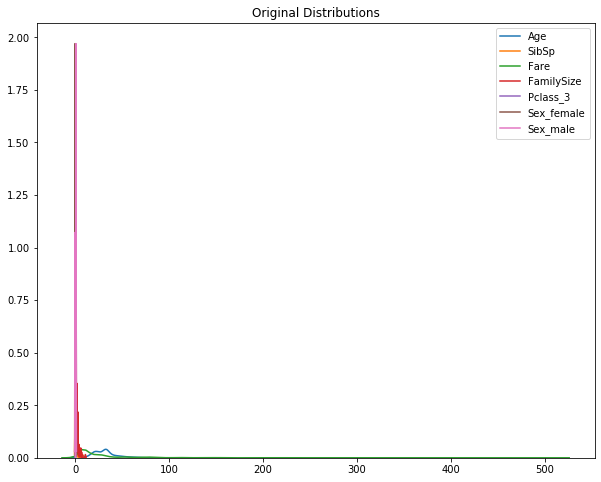

In [40]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

column_list = ['Age', 'SibSp', 'Fare', 'FamilySize', 'Pclass_3', 'Sex_female', 'Sex_male']

X_train_final[column_list].apply(sns.kdeplot, ax = ax1);

In [50]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# standard_scaler = preprocessing.StandardScaler()
# X_train_standard_scaled = standard_scaler.fit_transform(X_train_final)
# X_test_standard_scaled = standard_scaler.fit_transform(X_test_final)

scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_final)
# print(X_train_scaled.mean(axis=0))
X_test_scaled = scaler.transform(X_test_final)

df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_final.columns)

,count,mean,std,min,25%,50%,75%,max
Age,891.0,0.369522,0.166982,0.0,0.269234,0.371701,0.447097,1.0
SibSp,891.0,0.065376,0.137843,0.0,0.000000,0.000000,0.125000,1.0
Fare,891.0,0.062858,0.096995,0.0,0.015440,0.028213,0.060508,1.0
FamilySize,891.0,0.090460,0.161346,0.0,0.000000,0.000000,0.100000,1.0
Pclass_3,891.0,0.551066,0.497665,0.0,0.000000,1.000000,1.000000,1.0
Sex_female,891.0,0.352413,0.477990,0.0,0.000000,0.000000,1.000000,1.0
Sex_male,891.0,0.647587,0.477990,0.0,0.000000,1.000000,1.000000,1.0


#### Distribution of the scaled data

In [ ]:
df_X_train_scaled[['Age', 'SibSp', 'Fare', 'FamilySize', 'Pclass_3', 'Sex_female', 'Sex_male']].describe().T

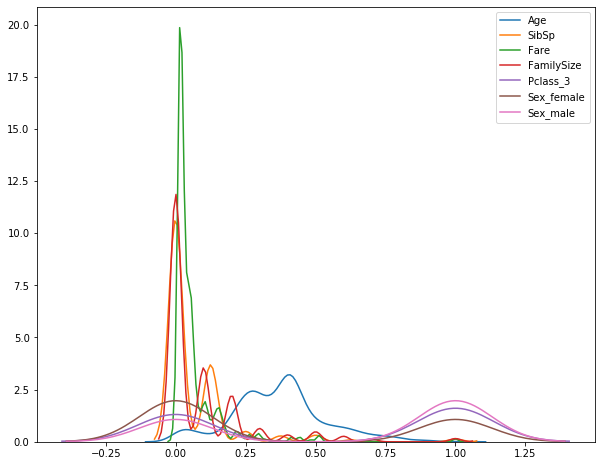

In [45]:
# plot original distribution plot
fig, (ax2) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Scaled Distributions')

column_list = ['Age', 'SibSp', 'Fare', 'FamilySize', 'Pclass_3', 'Sex_female', 'Sex_male']

df_X_train_scaled[column_list].apply(sns.kdeplot, ax = ax2);

In [51]:
# split the data into train and evaluation data
from sklearn.model_selection import train_test_split

# X, val_X, y, val_y = train_test_split(X_train_final, y_train, train_size=0.7, test_size=0.3, random_state=123, stratify=y_train)

# Applying scaled data
X, val_X, y, val_y = train_test_split(df_X_train_scaled, y_train, train_size=0.7, test_size=0.3, random_state=123, stratify=y_train)

print (X.shape)
print (val_X.shape)
print('All:', np.bincount(y_train) / float(len(y_train)) * 100.0)
print('Training:', np.bincount(y) / float(len(y)) * 100.0)
print('Test:', np.bincount(val_y) / float(len(val_y)) * 100.0)

(623, 855)
(268, 855)
All: [61.61616162 38.38383838]
Training: [61.63723917 38.36276083]
Test: [61.56716418 38.43283582]


## Sklearn StackingClassifier

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV

### Use GridSearchCV to find the best Random Forest estimator

In [83]:
param_grid_rf = {'n_estimators': [10, 20, 30], 
                 'min_samples_split': [2, 3, 4, 5],
                 'max_leaf_nodes':[90, 900, 9000, None]}

model_random_forest_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid_rf, verbose=3, n_jobs=-1)
model_random_forest_grid.fit(X, y)

results_grid_rf = pd.DataFrame(model_random_forest_grid.cv_results_)

print ("Parameters: ", model_random_forest_grid.get_params)

print("\nGridSearchCV best score - Random Forest: ", model_random_forest_grid.best_score_)
print("\nGridSearchCV best params - Random Forest: ", model_random_forest_grid.best_params_)
print("\nGridSearchCV best estimator - Random Forest: ", model_random_forest_grid.best_estimator_)

print ("\nGridSearchCV Score for validation data - Random Forest: ", model_random_forest_grid.score(val_X, val_y))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   14.1s finished


Parameters:  <bound method BaseEstimator.get_params of GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=

In [84]:
print(results_grid_rf.shape)
results_grid_rf.head(3)

(48, 16)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_leaf_nodes,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.077194,0.012450,0.008177,0.004009,90,2,10,"{'max_leaf_nodes': 90, 'min_samples_split': 2,...",0.848,0.832,0.784,0.830645,0.838710,0.826671,0.022203,29
1,0.156781,0.023956,0.009975,0.004230,90,2,20,"{'max_leaf_nodes': 90, 'min_samples_split': 2,...",0.840,0.832,0.784,0.846774,0.838710,0.828297,0.022639,21
2,0.215823,0.007767,0.013763,0.005477,90,2,30,"{'max_leaf_nodes': 90, 'min_samples_split': 2,...",0.856,0.816,0.792,0.846774,0.830645,0.828284,0.022729,24


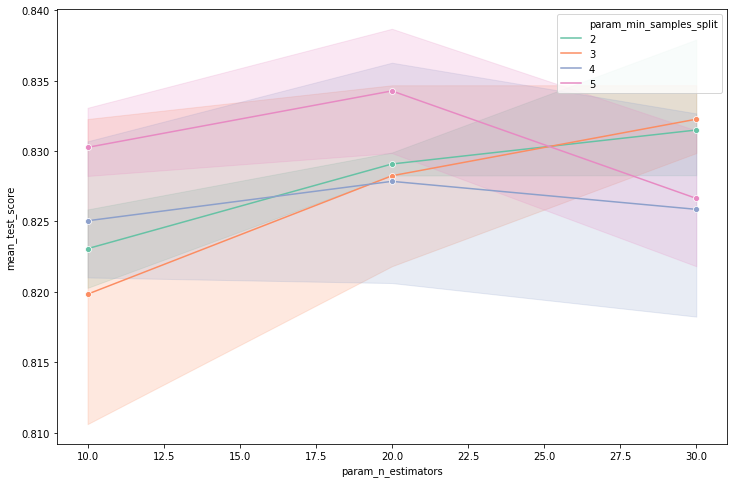

In [85]:
current_palette = sns.color_palette("Set2", 4)

plt.figure(figsize=(12,8))

sns.lineplot(data=results_grid_rf,
             x='param_n_estimators',
             y='mean_test_score',
             hue='param_min_samples_split',
             palette=current_palette,
             marker='o')

plt.show()

### Use GridSearchCV to find the best kNN estimator

In [86]:
param_grid_kNN = {'n_neighbors': [1, 5, 10, 15], 
                  'weights': ['uniform', 'distance'], 
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

model_knearest_neighbors_grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_kNN, verbose=3, n_jobs=-1)
model_knearest_neighbors_grid.fit(X, y)

results_grid_kNN = pd.DataFrame(model_knearest_neighbors_grid.cv_results_)

# print ("Parameters: ", model_knearest_neighbors_grid.get_params)

print("\nGridSearchCV best score - k-Nearest Neighbor: ", model_knearest_neighbors_grid.best_score_)
print("\nGridSearchCV best params - k-Nearest Neighbor: ", model_knearest_neighbors_grid.best_params_)
print("\nGridSearchCV best estimator - k-Nearest Neighbor: ", model_knearest_neighbors_grid.best_estimator_)

print ("\nGridSearchCV Score for validation data - k-Nearest Neighbor: ", model_knearest_neighbors_grid.score(val_X, val_y))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   10.1s finished



GridSearchCV best score - k-Nearest Neighbor:  0.8298967741935485

GridSearchCV best params - k-Nearest Neighbor:  {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}

GridSearchCV best estimator - k-Nearest Neighbor:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

GridSearchCV Score for validation data - k-Nearest Neighbor:  0.832089552238806


In [87]:
print(results_grid_kNN.shape)
results_grid_kNN.head(3)

(32, 16)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.204652,0.017036,0.132048,0.012624,auto,1,uniform,"{'algorithm': 'auto', 'n_neighbors': 1, 'weigh...",0.784,0.792,0.720,0.790323,0.766129,0.770490,0.026858,29
1,0.195675,0.015811,0.106319,0.007262,auto,1,distance,"{'algorithm': 'auto', 'n_neighbors': 1, 'weigh...",0.784,0.792,0.720,0.790323,0.766129,0.770490,0.026858,29
2,0.191088,0.008334,0.147808,0.015786,auto,5,uniform,"{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",0.864,0.792,0.768,0.838710,0.798387,0.812219,0.034463,13


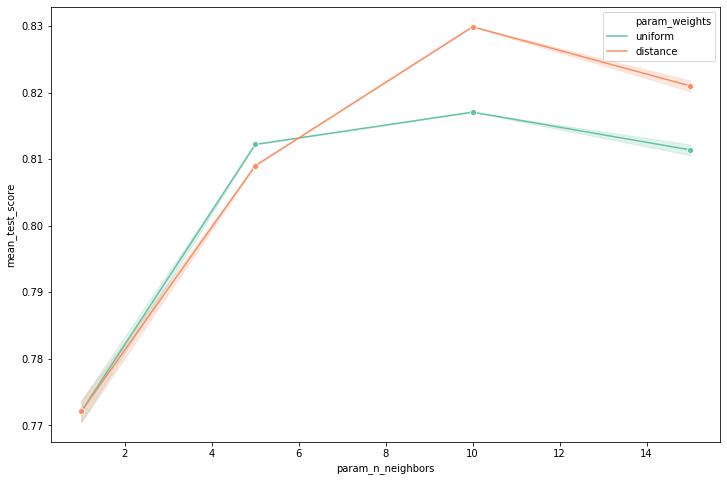

In [88]:
current_palette = sns.color_palette("Set2", 2)

plt.figure(figsize=(12,8))

sns.lineplot(data=results_grid_kNN,
             x='param_n_neighbors',
             y='mean_test_score',
             hue='param_weights',
             palette=current_palette,
             marker='o')

plt.show()

In [89]:
estimators = [
    ('rf', model_random_forest_grid.best_estimator_),
    ('kNN', model_knearest_neighbors_grid.best_estimator_)
]
# model_stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)
model_stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [95]:
# model_stacking_clf.fit(X, y).score(val_X, val_y)
model_stacking_clf.fit(X, y)
print("Parameters for Stacking Classifier:")
model_stacking_clf.get_params()

Parameters for Stacking Classifier:


{'cv': None,
 'estimators': [('rf',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', max_depth=None, max_features='auto',
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=30,
                          n_jobs=None, oob_score=False, random_state=42, verbose=0,
                          warm_start=False)),
  ('kNN',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                        metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                        weights='distance'))],
 'final_estimator__C': 1.0,
 'final_estimator__class_weight': None,
 'final_estimator__dual': False,
 'final_estimator__fit_intercept': True,
 'final_estimator__intercept_scaling': 1,

In [96]:
predictions = model_stacking_clf.predict(val_X)
predict_proba = model_stacking_clf.predict_proba(val_X)

print ("Count for validation data - actual: ", np.bincount(val_y))
print ("Count for validation data - prediction: ", np.bincount(predictions), "\n")

Count for validation data - actual:  [165 103]
Count for validation data - prediction:  [179  89] 



In [97]:
score_val_dataset = model_stacking_clf.score(val_X, val_y)
print ("Score for validation data - Stacked Classifier: ", score_val_dataset, "\n")

Score for validation data - Stacked Classifier:  0.835820895522388 



In [98]:
print("Predictions: ", predictions[0:6], "\n")
print("Prediction Probabilities:\n", predict_proba[0:6])

Predictions:  [0 1 0 0 0 0] 

Prediction Probabilities:
 [[0.81897739 0.18102261]
 [0.066223   0.933777  ]
 [0.89937739 0.10062261]
 [0.91852529 0.08147471]
 [0.91607186 0.08392814]
 [0.73091436 0.26908564]]


In [100]:
from sklearn.metrics import classification_report, roc_curve

print("Classification Report - Validation Data")
print(classification_report(val_y, model_stacking_clf.predict(val_X)))

Classification Report - Validation Data
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       165
           1       0.83      0.72      0.77       103

    accuracy                           0.84       268
   macro avg       0.83      0.81      0.82       268
weighted avg       0.84      0.84      0.83       268



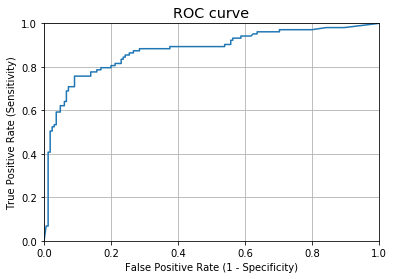

In [101]:
fpr, tpr, thresholds = roc_curve(val_y, predict_proba[:,1])

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

<b>Note</b>: I am not predicting on the test data as I am not using this notebook for submission.